# Python 101 - Numerical Methods

In [1]:
#import the packages you need
import numpy as np
import copy
import pandas as pd
from matplotlib import pyplot as plt

## Exercise 01: Linear Advection Equation

The goal of this first exercise is to investigate stability and accuracy of different numerical schemes for the one-dimensional linear advection equation:

$$\partial_t \phi + u_0 \partial_x \phi = 0 $$

where $\phi$ is some quantety that is advected around and $u_0$ is a constant zonal wind. As spatial grid use the 45°-latitude circle of the earth with a longitude resolution of $\Delta\lambda$ = 1° or equally $N_x = 360$ grid points, which leads to a grid spacing of:

$$L_x = 2\pi r_e cos(45°) = \Delta_x * N_x$$

thus

$$\Delta_x = 2\pi r_e cos(45°) / N_x$$

In [3]:
r_e = 6371 # km
n_x = 360
latitude = np.deg2rad(45)
L_x = np.round(2 * np.pi * r_e * np.cos(latitude), 6)
delta_x = L_x / n_x
range_x = np.linspace(0, L_x, n_x)

As initial condition, use a Gaussian bell-curve

$$\phi(x, t=0) = \hat\phi exp(-(\frac{(x-x_0)^2}{2\sigma^2}))$$

placed in the western part of the domain ($x_0 = 5000 km$), with a width of $\sigma = 500$ km and an amplitude of $\hat\phi = 1$. With this initial condition, compute a 15-day forecast for a windspeed of $u_0 = 10m/s$ with the following methods to evaluate their basic properties.

Optional: Add some small-amplitude random noise to the initial condition, e.g. use **np.random.normal(0, 0.001, Nx)** from the **numpy-package**. 

In [4]:
x_0 = 5000
sigma = 500
amp = 1
u_0 = 10 / 1000

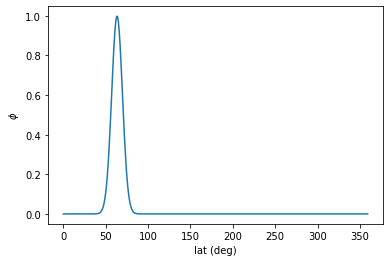

In [67]:
phi_0 = amp * np.exp(-(range_x - 5000) ** 2 / (2 * sigma ** 2))
plt.plot(phi_0);
plt.ylabel(r'$\phi$');
plt.xlabel("lat (deg)");

### Part a)
Exact solution. Work out the exact solution of the 15-day forecast (without the noise) and plot it together with the initial condition. Use this exact solution as a reference for the following experiments.

-> The advection equation is a hyperbolic PDE with unique solution determinde by initial condition:

### **$$\phi(x,t) = \phi(x-ut,0)$$**

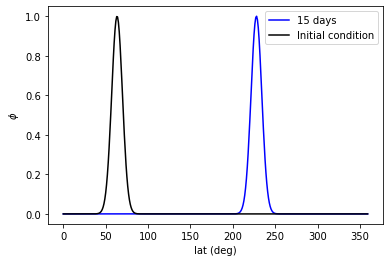

In [68]:
t_d15 = 15 * 86400
x_d15 = range_x - u_0 * t_d15
phi_d15 = amp * np.exp(-( x_d15 - 5000) ** 2 / (2 * sigma ** 2))
plt.plot(phi_d15, '-b',label="15 days")
plt.plot(phi_0, '-k', label="Initial condition")
plt.legend();
plt.ylabel(r'$\phi$');
plt.xlabel("lat (deg)");

### Part b)
Euler-upstream-scheme (forward in time, backward in space). Plot the forecast computed from this method together with the exact solution from (a). 

**In case you don't remember, courant number for 1D**:

#### $$ CFL = \mu = u \frac{\Delta t}{\Delta x} $$

**Euler-upstream-scheme**:

#### $$\frac{\phi^{t+1}_i - \phi^{t}_i}{\Delta t} +  u_0\frac{\phi^{t}_{i} - \phi^{t}_{i-1}}{\Delta x} = 0$$

#### $$\phi^{t+1}_i = \phi^{t}_i - u_0\frac{\Delta t}{\Delta x}(\phi^{t}_{i} - \phi^{t}_{i-1})$$

In [19]:
# 1 - define the temporal resolution
delta_t_courant_1 = (delta_x / u_0)
print("For a courant number equal to be less than 1 (our limit) delta_t < %.2f" %(delta_t_courant_1))

For a courant number equal to be less than 1 (our limit) delta_t < 7862.67


In [20]:
delta_t = 6000
print("Number of time steps: %d | CFL: %.2f" % (int(t_d15/delta_t), u_0 * delta_t / delta_x))

Number of time steps: 216 | CFL: 0.76


For a courant number equal to be less than 1 (our limit) delta_t < 7862.67
Number of steps required for 15 days 216.00
Actual: Courant number 0.76 - Stable True


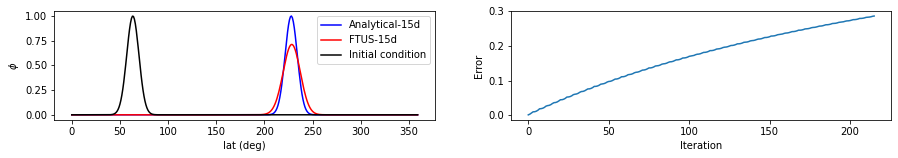

In [70]:
# 2 - develop the numerical method requested
from FDMethodsAE import *
fd_deployer = FinitDifferenceAdvection(phi_0, delta_x, delta_t, u_0)
phi, error_growth = fd_deployer.fd_solver("ftus", "direct", t_d15, True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
ax[0].plot(phi_d15, '-b',label="Analytical-15d")
ax[0].plot(phi, '-r',label="FTUS-15d")
ax[0].plot(phi_0, '-k', label="Initial condition")
ax[0].legend();
ax[0].set_ylabel(r'$\phi$');
ax[0].set_xlabel("lat (deg)");
ax[1].plot(error_growth);
ax[1].set_ylabel("Error");
ax[1].set_xlabel("Iteration");

Try out different Courant numbers ($\mu$) to verify the results from the lecture, i.e.: unstable for $\mu$ > 1, stable for $\mu$ < 1, diffusive (amplitude decay), more diffusive for smaller $\mu$.

For a courant number equal to be less than 1 (our limit) delta_t < 7862.67
Number of steps required for 15 days 164.84
Actual: Courant number 1.00 - Stable True


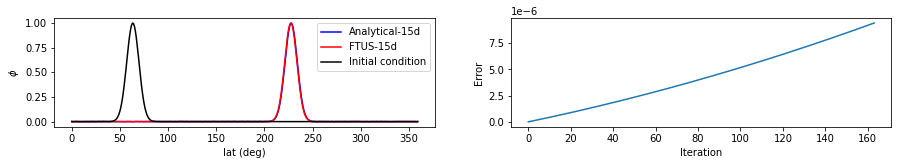

In [71]:
fd_deployer = FinitDifferenceAdvection(phi_0, delta_x, 7862 , u_0)
phi, error_growth = fd_deployer.fd_solver("ftus", "direct", t_d15, True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
ax[0].plot(phi_d15, '-b',label="Analytical-15d")
ax[0].plot(phi, '-r',label="FTUS-15d")
ax[0].plot(phi_0, '-k', label="Initial condition")
ax[0].legend();
ax[0].set_ylabel(r'$\phi$');
ax[0].set_xlabel("lat (deg)");
ax[1].plot(error_growth);
ax[1].set_ylabel("Error");
ax[1].set_xlabel("Iteration");

### Part c)
Euler-downstream-scheme (forward in time, foreward in space). Show that this scheme is unstable, even for Courant numbers smaller than one

For the Euler-downstream-scheme:

## $$\frac{\phi^{t+1}_i - \phi^{t}_i}{\Delta t} +  u_0\frac{\phi^{t}_{i+1} - \phi^{t}_{i}}{\Delta x} = 0$$

## $$\phi^{t+1}_i = \phi^{t}_i - u_0\frac{\Delta t}{\Delta x}(\phi^{t}_{i+1} - \phi^{t}_{i})$$

Note: This method will not work since the information flows up-stream and not down-stream

For a courant number equal to be less than 1 (our limit) delta_t < 7862.67
Number of steps required for 15 days 216.00
Actual: Courant number 0.76 - Stable True
Simulation unstable at step 7


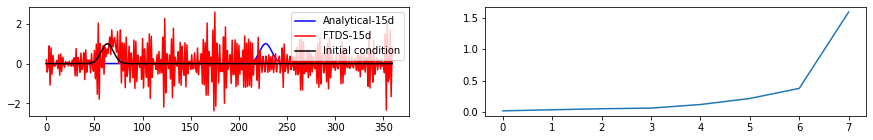

In [41]:
fd_deployer = FinitDifferenceAdvection(phi_0, delta_x, delta_t, u_0)
phi, error_growth = fd_deployer.fd_solver("ftds", "direct", t_d15, True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
ax[0].plot(phi_d15, '-b',label="Analytical-15d")
ax[0].plot(phi, '-r',label="FTDS-15d")
ax[0].plot(phi_0, '-k', label="Initial condition")
ax[0].legend();
ax[0].set_ylabel(r'$\phi$');
ax[0].set_xlabel("lat (deg)");
ax[1].plot(error_growth);
ax[1].set_ylabel("Error");
ax[1].set_xlabel("Iteration");

### Part d)
Euler-centered-scheme (forward in time, centered in space). Show that this scheme is unstable, even for Courant numbers smaller than one

For the Euler-centered-scheme or Forward-Time Central-Space (FTCS) Method:

## $$\frac{\phi^{t+1}_i - \phi^{t}_i}{\Delta t} +  u_0\frac{\phi^{t}_{i+1} - \phi^{t}_{i-1}}{2\Delta x} = 0$$

## $$\phi^{t+1}_i = \phi^{t}_i - u_0\frac{\Delta t}{2\Delta x}(\phi^{t}_{i+1} - \phi^{t}_{i-1})$$

For a courant number equal to be less than 1 (our limit) delta_t < 7862.67
Number of steps required for 15 days 216.00
Actual: Courant number 0.76 - Stable True
Simulation unstable at step 31


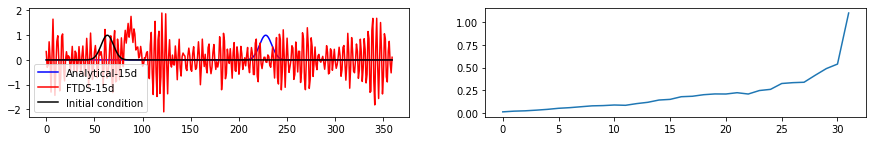

In [44]:
fd_deployer = FinitDifferenceAdvection(phi_0, delta_x, delta_t, u_0)
phi, error_growth = fd_deployer.fd_solver("ftcs", "direct", t_d15, True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
ax[0].plot(phi_d15, '-b',label="Analytical-15d")
ax[0].plot(phi, '-r',label="FTDS-15d")
ax[0].plot(phi_0, '-k', label="Initial condition")
ax[0].legend();
ax[0].set_ylabel(r'$\phi$');
ax[0].set_xlabel("lat (deg)");
ax[1].plot(error_growth);
ax[1].set_ylabel("Error");
ax[1].set_xlabel("Iteration");

### Part e)
Leapfrog-scheme (centered in time, centered in space). Show that this scheme is stable for $\mu < 1$ and unstable for $\mu > 1$. Compare amplitude errors for different Courant numbers to the Euler-upstream-scheme. To see the effects of artificial numerical dispersion, increase $k\Delta x$ by either making the initial Gauss-peak narrower or the resolution coarser.

## $$\frac{\phi^{t+1}_i - \phi^{t-1}_i}{2\Delta t} +  u_0\frac{\phi^{t}_{i+1} - \phi^{t}_{i-1}}{2\Delta x} = 0$$

## $$\phi^{t+1}_i = \phi^{t-1}_i - u_0\frac{\Delta t}{\Delta x}(\phi^{t}_{i+1} - \phi^{t}_{i-1})$$


For a courant number equal to be less than 1 (our limit) delta_t < 7862.67
Number of steps required for 15 days 216.00
Actual: Courant number 0.76 - Stable True


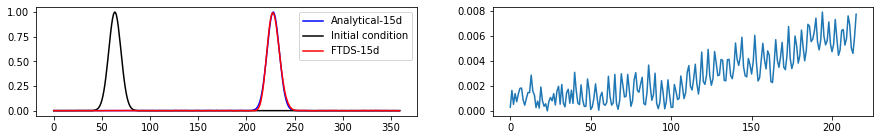

In [46]:
fd_deployer = FinitDifferenceAdvection(phi_0, delta_x, delta_t, u_0)
phi, error_growth = fd_deployer.fd_solver("leapfrog", "numpy", t_d15, True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
ax[0].plot(phi_d15, '-b',label="Analytical-15d")
ax[0].plot(phi_0, '-k', label="Initial condition")
ax[0].plot(phi, '-r',label="FTDS-15d")
ax[0].legend();
ax[0].set_ylabel(r'$\phi$');
ax[0].set_xlabel("lat (deg)");
ax[1].plot(error_growth);
ax[1].set_ylabel("Error");
ax[1].set_xlabel("Iteration");

## Bonus - Interesting things to do

It is simple to make this methods but how can you make them faster? Can you figure out a best way to implement them?

In [47]:
from timeit import default_timer as timer

Check perfomance of the different methods implemented:

In [48]:
def test_benchmark(method_name, technique_name, factor_time, t_max):
    start = timer()
    phi, error_growth = fd_deployer.fd_solver(method_name, technique_name, factor_time * t_max, True)
    end = timer()
    return end - start

In [57]:
time_array = []
label_array = []
msps = [] # million stencils per second

methods_test = ["leapfrog", "ftus" ]
techniques_test = ['direct', 'numpy', 'roll']

df_time = pd.DataFrame(columns=techniques_test, index=methods_test)
df_msps = pd.DataFrame(columns=techniques_test, index=methods_test)

fd_deployer = FinitDifferenceAdvection(phi_0, delta_x, delta_t, u_0)

factor_time = 100
iterations = int(t_d15 / fd_deployer.delta_t) * factor_time
n_stencil = len(fd_deployer.phi)

For a courant number equal to be less than 1 (our limit) delta_t < 7862.67
Number of steps required for 15 days 216.00
Actual: Courant number 0.76 - Stable True


In [58]:
for method_name in methods_test:
    for technique_name in techniques_test:
        time_ = test_benchmark(method_name, technique_name, factor_time, t_d15)
        time_array.append(time_)
        df_time.loc[method_name, technique_name] = time_ / factor_time
        df_msps.loc[method_name, technique_name] = np.round(n_stencil * iterations / time_ / 1e6, 4)

In [59]:
display(df_time)

,direct,numpy,roll
leapfrog,0.058654,0.003101,0.007129
ftus,0.053206,0.002713,0.004862


In [60]:
display(df_msps)

,direct,numpy,roll
leapfrog,1.3257,25.0734,10.9071
ftus,1.4615,28.6625,15.993


## Implementations using pystencils?

In [56]:
## TODO